In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline  

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
import hdbscan
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from utils import *

In [91]:
def plot_projected_clusters(projection, clusterer=None):
    if clusterer is not None:
        n_colors = sum(np.unique(clusterer.labels_) >= 0)
        color_palette = sns.color_palette('muted', n_colors)
        color_palette = {k: v for k, v in enumerate(color_palette)}
        color_palette[-1] = (0.5, 0.5, 0.5)
        cluster_colors = [color_palette[x] for x in clusterer.labels_]
        cluster_member_colors = [sns.desaturate(x, p) for x, p in
                                 zip(cluster_colors, clusterer.probabilities_)]
    else:
        cluster_member_colors = None
        
    plt.figure(figsize=(8, 8))
    plt.scatter(*projection.T, c=cluster_member_colors, alpha=0.25)
    
    return color_palette, cluster_member_colors

In [73]:
def clustering_report(clusters, labels):
    clusters_unique = np.unique(clusters)
    labels_unique = np.unique(labels)
    report = pd.DataFrame(columns=np.concatenate([['cluster', 'size'], labels_unique]))
    for cluster in clusters_unique:
        cluster_labels = labels[clusters == cluster].values
        row = {'cluster': cluster, 'size': len(cluster_labels)}
        for label in labels_unique:
            row[label] = (cluster_labels == label).sum()
        report = report.append(row, ignore_index=True)
    return report

# Data preparation

In [ ]:
kids_x_gaia = process_kids('/home/snakoneczny/data/KiDS/KiDS.DR3.x.GAIA.cols.csv', with_colors=False)

In [ ]:
kids_x_gaia, kids_x_gaia_sdss = add_sdss_info(kids_x_gaia, '/home/snakoneczny/data/KiDS/KiDS.DR3.x.GAIA.x.SDSS.DR14.csv')

In [4]:
kids_x_gaia = pd.read_csv('/home/snakoneczny/data/KiDS/KiDS.DR3.x.GAIA.cols_more.csv')
kids_x_gaia.shape

(1525462, 33)

In [5]:
kids_x_gaia_sdss = pd.read_csv('/home/snakoneczny/data/KiDS/KiDS.DR3.x.GAIA.x.SDSS.DR14.csv',
                               usecols=['ID', 'CLASS', 'SUBCLASS', 'Z'])
kids_x_gaia_sdss.shape

(29297, 4)

In [6]:
kids_x_gaia_clean = clean_kids(kids_x_gaia)

Droping NANs: 1525462 left
Removing flags: 599223 left
Removing errors bigger than observations: 598856 left
Removing limiting magnitudes: 513108 left


In [7]:
kids_x_gaia_clean = calib_mag_for_ext(kids_x_gaia_clean)

In [8]:
kids_x_gaia_clean = add_colors(kids_x_gaia_clean)

In [9]:
kids_x_gaia_clean = kids_x_gaia_clean.merge(kids_x_gaia_sdss, how='left', on='ID')
kids_x_gaia_clean['CLASS'].describe()

count     10445
unique        3
top        STAR
freq       5597
Name: CLASS, dtype: object

In [43]:
kids_x_gaia_clean['CLASS_FILLED'] = kids_x_gaia_clean['CLASS'].fillna(value='UNKNOWN')

In [72]:
np.unique(kids_x_gaia_clean['CLASS_FILLED'], return_counts=True)

(array(['GALAXY', 'QSO', 'STAR', 'UNKNOWN'], dtype=object),
 array([  2176,   2672,   5597, 502663]))

In [14]:
kids_x_gaia_sdss = kids_x_gaia_clean.dropna(axis=0, subset=['CLASS'])
kids_x_gaia_sdss.shape

(10445, 47)

In [44]:
kids_x_gaia_sampled = kids_x_gaia_clean.sample(10000, random_state=1467)

In [45]:
X = kids_x_gaia_clean[BAND_COLUMNS]
X_colors = kids_x_gaia_clean[COLOR_COLUMNS]

X_sampled = kids_x_gaia_sampled[BAND_COLUMNS]
X_colors_sampled = kids_x_gaia_sampled[COLOR_COLUMNS]

X_sdss = kids_x_gaia_sdss[BAND_COLUMNS]
X_colors_sdss = kids_x_gaia_sdss[COLOR_COLUMNS]

# Data description

In [13]:
kids_x_gaia_clean.columns

Index(['ID', 'SCID', 'SLID', 'SID', 'RAJ2000', 'DECJ2000', 'SG2DPHOT',
       'CLASS_STAR', 'FLAG_U', 'FLAG_G', 'FLAG_R', 'FLAG_I', 'IMAFLAGS_ISO_U',
       'IMAFLAGS_ISO_G', 'IMAFLAGS_ISO_R', 'IMAFLAGS_ISO_I', 'MAG_GAAP_U',
       'MAG_GAAP_G', 'MAG_GAAP_R', 'MAG_GAAP_I', 'MAGERR_GAAP_U',
       'MAGERR_GAAP_G', 'MAGERR_GAAP_R', 'MAGERR_GAAP_I', 'ZPT_OFFSET_U',
       'ZPT_OFFSET_G', 'ZPT_OFFSET_R', 'ZPT_OFFSET_I', 'EXT_SFD_U',
       'EXT_SFD_G', 'EXT_SFD_R', 'EXT_SFD_I', 'TILE_FLAG', 'MAG_GAAP_CALIB_U',
       'MAG_GAAP_CALIB_G', 'MAG_GAAP_CALIB_R', 'MAG_GAAP_CALIB_I',
       'MAG_GAAP_CALIB_U-G', 'MAG_GAAP_CALIB_G-R', 'MAG_GAAP_CALIB_R-I'],
      dtype='object')

In [11]:
kids_x_gaia_clean[['ID', 'SCID', 'SLID', 'SID', 'RAJ2000', 'DECJ2000', 'SG2DPHOT', 'CLASS_STAR']].describe()

,SCID,SLID,SID,RAJ2000,DECJ2000,SG2DPHOT,CLASS_STAR
count,5.131080e+05,5.131080e+05,513108.000000,513108.000000,513108.000000,513108.000000,513108.000000
mean,2.396326e+06,2.495069e+07,60035.113779,198.279781,-7.835637,4.622467,0.885277
std,1.831871e+03,1.608570e+04,34175.451493,81.484099,13.989279,1.074026,0.144519
min,2.392971e+06,2.493472e+07,2.000000,0.000352,-34.652252,0.000000,0.025867
25%,2.394801e+06,2.493850e+07,31257.000000,138.813497,-2.953710,5.000000,0.874080
50%,2.396331e+06,2.494291e+07,58835.000000,206.697009,-0.636654,5.000000,0.904757
75%,2.397911e+06,2.497271e+07,86627.000000,230.269590,0.816758,5.000000,0.939387
max,2.400051e+06,2.499136e+07,172116.000000,359.999819,3.014887,5.000000,0.999843


In [10]:
kids_x_gaia_clean[[
    'MAG_GAAP_U', 'MAG_GAAP_G', 'MAG_GAAP_R', 'MAG_GAAP_I',
    'MAG_GAAP_CALIB_U', 'MAG_GAAP_CALIB_G', 'MAG_GAAP_CALIB_R', 'MAG_GAAP_CALIB_I',
    'MAGERR_GAAP_U', 'MAGERR_GAAP_G', 'MAGERR_GAAP_R', 'MAGERR_GAAP_I',
    'ZPT_OFFSET_U', 'ZPT_OFFSET_G', 'ZPT_OFFSET_R', 'ZPT_OFFSET_I',
    'EXT_SFD_U', 'EXT_SFD_G', 'EXT_SFD_R', 'EXT_SFD_I',
]].describe()

,MAG_GAAP_U,MAG_GAAP_G,MAG_GAAP_R,MAG_GAAP_I,MAG_GAAP_CALIB_U,MAG_GAAP_CALIB_G,MAG_GAAP_CALIB_R,MAG_GAAP_CALIB_I,MAGERR_GAAP_U,MAGERR_GAAP_G,MAGERR_GAAP_R,MAGERR_GAAP_I,ZPT_OFFSET_U,ZPT_OFFSET_G,ZPT_OFFSET_R,ZPT_OFFSET_I,EXT_SFD_U,EXT_SFD_G,EXT_SFD_R,EXT_SFD_I
count,513108.000000,513108.000000,513108.000000,513108.000000,513108.000000,513108.000000,513108.000000,513108.000000,513108.000000,513108.000000,513108.000000,513108.000000,513108.000000,513108.000000,5.131080e+05,513108.000000,513108.000000,513108.000000,513108.000000,513108.000000
mean,21.863194,19.973984,19.083487,18.582601,21.631312,19.843535,18.975575,18.521296,0.089284,0.005159,0.002397,0.005677,-0.034777,0.014579,-2.725793e-03,0.018454,0.197105,0.145028,0.105186,0.079760
std,1.507800,1.155058,1.046303,1.063991,1.513316,1.156232,1.047484,1.065029,0.102098,0.005112,0.002002,0.005633,0.067495,0.092784,2.672651e-02,0.055319,0.129879,0.095564,0.069311,0.052556
min,15.708885,15.820495,15.023022,14.567034,15.564224,15.694784,14.955441,14.597723,0.000161,0.000078,0.000065,0.000102,-0.604706,-0.134290,-2.116046e-01,-0.343036,0.039088,0.028761,0.020860,0.015817
25%,20.769844,19.146759,18.305550,17.788025,20.531232,19.017748,18.196061,17.726824,0.015165,0.001545,0.000831,0.001751,-0.061697,-0.017729,-6.597140e-03,-0.002747,0.105133,0.077356,0.056105,0.042543
50%,21.894455,20.105845,19.207088,18.632133,21.661301,19.977946,19.096616,18.568402,0.042712,0.003622,0.001831,0.003746,-0.018493,0.008558,-1.728258e-08,0.015515,0.158467,0.116598,0.084567,0.064124
75%,23.165161,20.861967,19.923803,19.406265,22.931605,20.731243,19.817231,19.344108,0.135014,0.007114,0.003431,0.007639,0.000000,0.032189,1.906458e-03,0.040004,0.238524,0.175504,0.127290,0.096520
max,24.299976,23.885756,22.382982,22.224367,24.373394,23.860460,22.310009,22.150781,1.198221,0.120231,0.038350,0.103235,0.295657,0.699730,1.005186e-01,0.440925,0.873177,0.642476,0.465977,0.353336


In [12]:
kids_x_gaia_clean[[
    'FLAG_U', 'FLAG_G', 'FLAG_R', 'FLAG_I',
    'IMAFLAGS_ISO_U', 'IMAFLAGS_ISO_G', 'IMAFLAGS_ISO_R', 'IMAFLAGS_ISO_I',
    'TILE_FLAG',
]].describe()

,FLAG_U,FLAG_G,FLAG_R,FLAG_I,IMAFLAGS_ISO_U,IMAFLAGS_ISO_G,IMAFLAGS_ISO_R,IMAFLAGS_ISO_I,TILE_FLAG
count,513108.0,513108.0,513108.0,513108.0,513108.0,513108.0,513108.0,513108.0,513108.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
kids_x_gaia.head()

,ID,SCID,SLID,SID,RAJ2000,DECJ2000,SG2DPHOT,CLASS_STAR,FLAG_U,FLAG_G,...,MAGERR_GAAP_I,ZPT_OFFSET_U,ZPT_OFFSET_G,ZPT_OFFSET_R,ZPT_OFFSET_I,EXT_SFD_U,EXT_SFD_G,EXT_SFD_R,EXT_SFD_I,TILE_FLAG
0,KIDS J235805.17-313749.95,2398431,24945531,3679,359.521537,-31.630541,0,0.028628,0,0,...,5.648071e-04,0.0,-0.012365,0.0,0.007727,0.079173,0.058255,0.042251,0.032038,8
1,KIDS J235957.31-313822.63,2398431,24945531,4271,359.988804,-31.639619,4,0.979243,0,4,...,-6.921248e+06,0.0,-0.012365,0.0,0.007727,0.068926,0.050715,0.036783,0.027891,8
2,KIDS J235907.14-313821.45,2398431,24945531,4469,359.779740,-31.639292,4,0.977403,2,6,...,-1.268813e+07,0.0,-0.012365,0.0,0.007727,0.086124,0.063369,0.045960,0.034850,8
3,KIDS J000212.69-313817.32,2398431,24945531,4576,0.552891,-31.638144,4,0.944895,0,0,...,3.524196e-04,0.0,-0.012365,0.0,0.007727,0.075724,0.055717,0.040411,0.030642,8
4,KIDS J235955.44-313817.51,2398431,24945531,5115,359.981020,-31.638196,4,0.967481,0,0,...,2.797980e-04,0.0,-0.012365,0.0,0.007727,0.068926,0.050715,0.036783,0.027891,8


# Kids x Gaia x SDSS

## Standalone bands

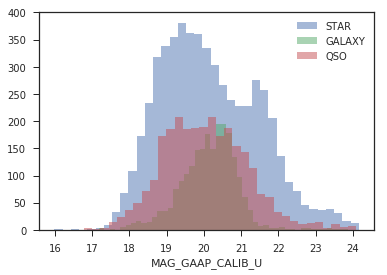

In [25]:
sns.set(style='ticks')
for c in ['STAR', 'GALAXY', 'QSO']:
    sns.distplot(kids_x_gaia_sdss.loc[kids_x_gaia_sdss['CLASS'] == c][MAG_GAAP_CALIB_U], label=c, kde=False, rug=False,
                 hist_kws={'alpha': 0.5})
plt.legend()

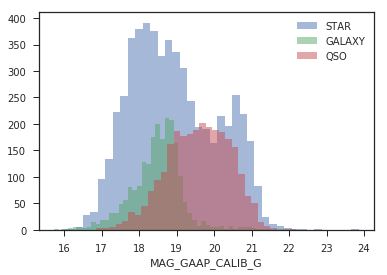

In [26]:
sns.set(style='ticks')
for c in ['STAR', 'GALAXY', 'QSO']:
    sns.distplot(kids_x_gaia_sdss.loc[kids_x_gaia_sdss['CLASS'] == c][MAG_GAAP_CALIB_G], label=c, kde=False, rug=False,
                 hist_kws={'alpha': 0.5})
plt.legend()

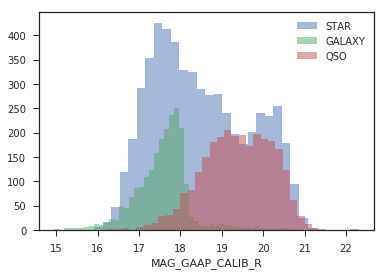

In [27]:
sns.set(style='ticks')
for c in ['STAR', 'GALAXY', 'QSO']:
    sns.distplot(kids_x_gaia_sdss.loc[kids_x_gaia_sdss['CLASS'] == c][MAG_GAAP_CALIB_R], label=c, kde=False, rug=False,
                 hist_kws={'alpha': 0.5})
plt.legend()

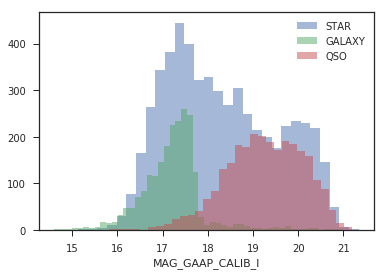

In [28]:
sns.set(style='ticks')
for c in ['STAR', 'GALAXY', 'QSO']:
    sns.distplot(kids_x_gaia_sdss.loc[kids_x_gaia_sdss['CLASS'] == c][MAG_GAAP_CALIB_I], label=c, kde=False, rug=False,
                 hist_kws={'alpha': 0.5})
plt.legend()

## Paired bands

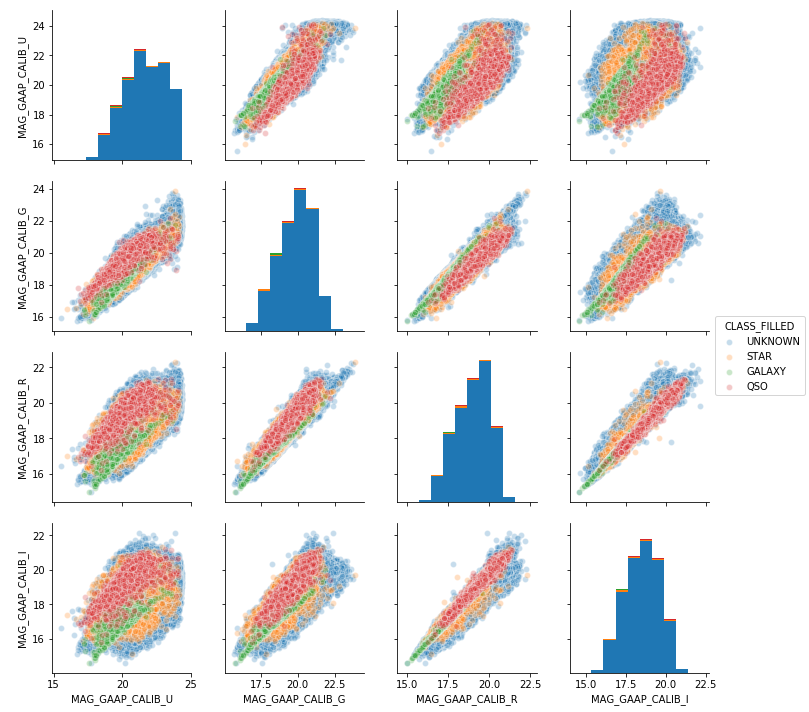

In [13]:
sns.pairplot(kids_x_gaia_clean[np.concatenate([BAND_COLUMNS, ['CLASS']])],
             hue='CLASS_FILLED', plot_kws={'alpha': 0.25})

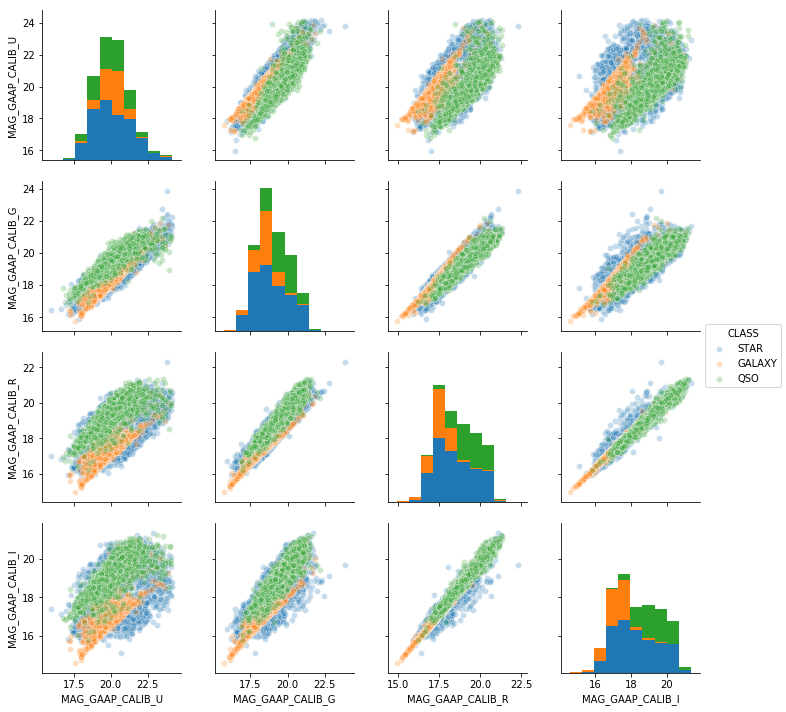

In [20]:
sns.pairplot(kids_x_gaia_clean[np.concatenate([BAND_COLUMNS, ['CLASS']])], hue='CLASS', plot_kws={'alpha': 0.25})

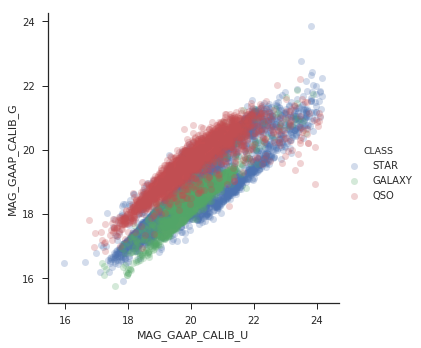

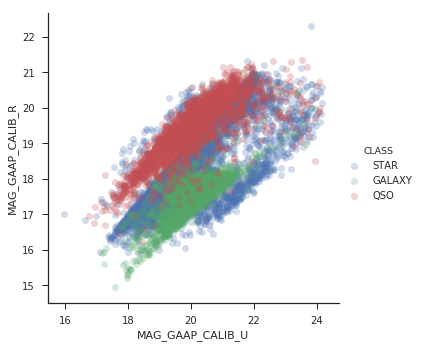

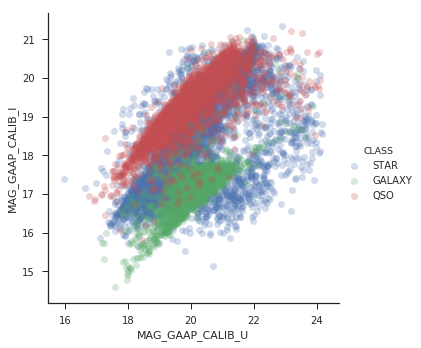

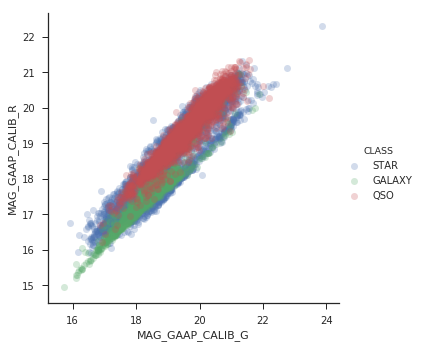

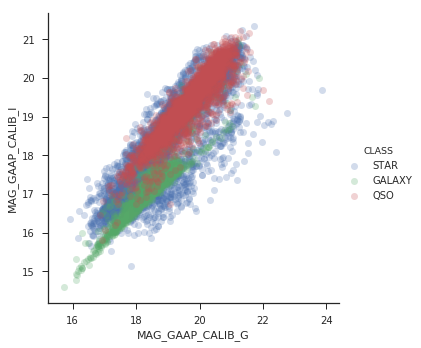

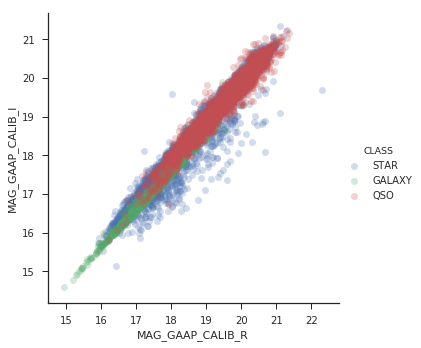

In [40]:
for b_1, b_2 in BAND_PAIRS:
    sns.set(style='ticks')
    sns.lmplot(x=b_1, y=b_2, hue='CLASS', data=kids_x_gaia_sdss, fit_reg=False, scatter_kws={'alpha': 0.25})

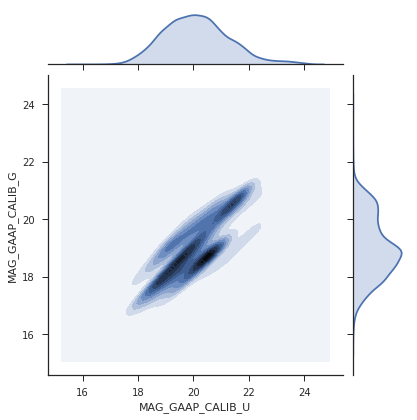

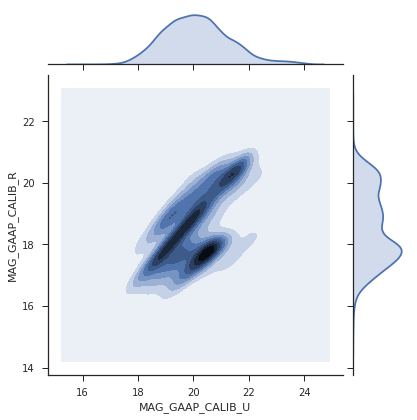

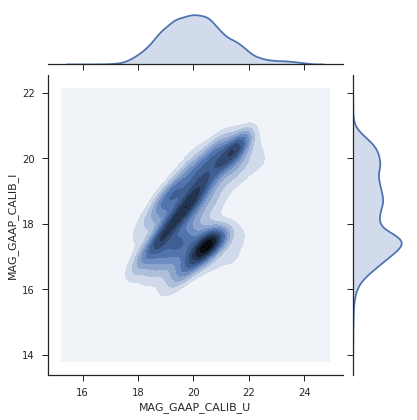

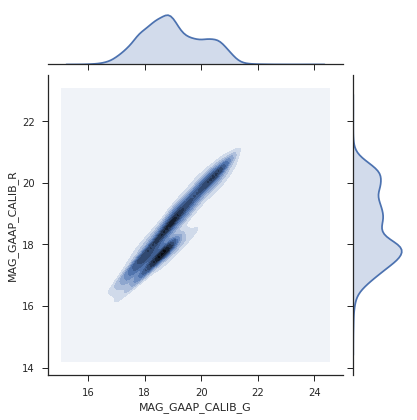

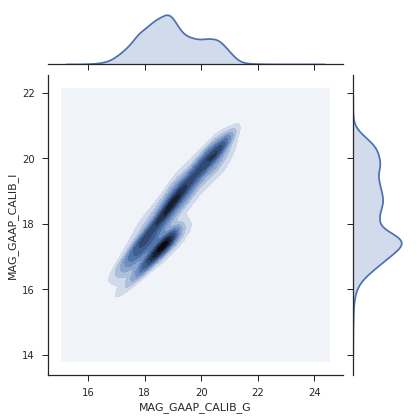

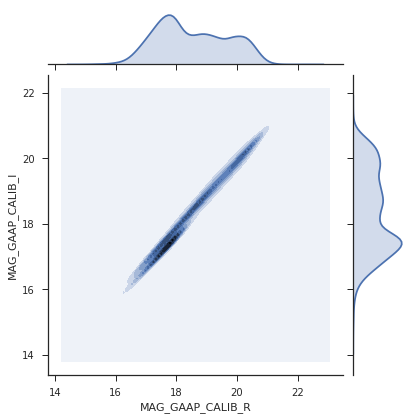

In [29]:
for b_1, b_2 in BAND_PAIRS:
    sns.set(style='ticks')
    sns.jointplot(kids_x_gaia_sdss[b_1], kids_x_gaia_sdss[b_2], kind='kde', stat_func=None)

## Standalone colors

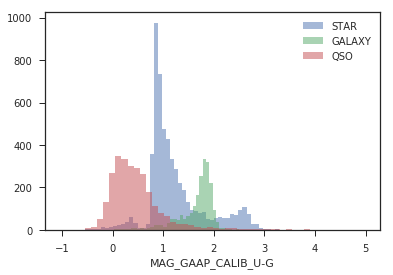

In [94]:
sns.set(style='ticks')
for c in ['STAR', 'GALAXY', 'QSO']:
    sns.distplot(kids_x_gaia_sdss.loc[kids_x_gaia_sdss['CLASS'] == c][MAG_GAAP_CALIB_UG], label=c, kde=False, rug=False,
                 hist_kws={'alpha': 0.5})
plt.legend()

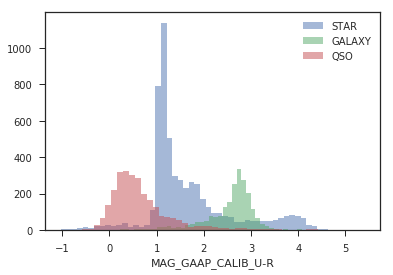

In [95]:
sns.set(style='ticks')
for c in ['STAR', 'GALAXY', 'QSO']:
    sns.distplot(kids_x_gaia_sdss.loc[kids_x_gaia_sdss['CLASS'] == c][MAG_GAAP_CALIB_UR], label=c, kde=False, rug=False,
                 hist_kws={'alpha': 0.5})
plt.legend()

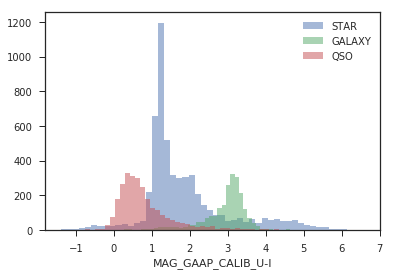

In [96]:
sns.set(style='ticks')
for c in ['STAR', 'GALAXY', 'QSO']:
    sns.distplot(kids_x_gaia_sdss.loc[kids_x_gaia_sdss['CLASS'] == c][MAG_GAAP_CALIB_UI], label=c, kde=False, rug=False,
                 hist_kws={'alpha': 0.5})
plt.legend()

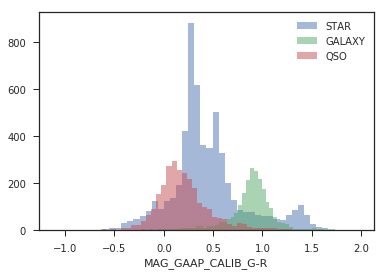

In [97]:
sns.set(style='ticks')
for c in ['STAR', 'GALAXY', 'QSO']:
    sns.distplot(kids_x_gaia_sdss.loc[kids_x_gaia_sdss['CLASS'] == c][MAG_GAAP_CALIB_GR], label=c, kde=False, rug=False,
                 hist_kws={'alpha': 0.5})
plt.legend()

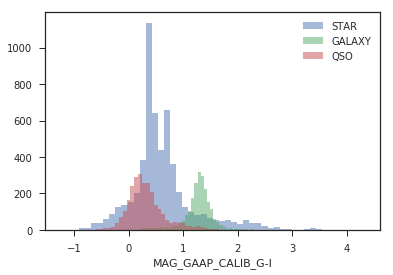

In [98]:
sns.set(style='ticks')
for c in ['STAR', 'GALAXY', 'QSO']:
    sns.distplot(kids_x_gaia_sdss.loc[kids_x_gaia_sdss['CLASS'] == c][MAG_GAAP_CALIB_GI], label=c, kde=False, rug=False,
                 hist_kws={'alpha': 0.5})
plt.legend()

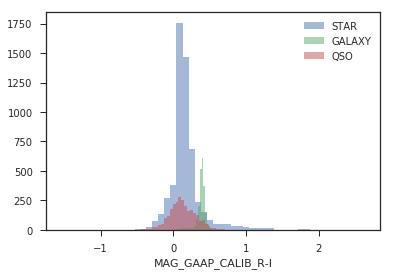

In [99]:
sns.set(style='ticks')
for c in ['STAR', 'GALAXY', 'QSO']:
    sns.distplot(kids_x_gaia_sdss.loc[kids_x_gaia_sdss['CLASS'] == c][MAG_GAAP_CALIB_RI], label=c, kde=False, rug=False,
                 hist_kws={'alpha': 0.5})
plt.legend()

## Paired colors

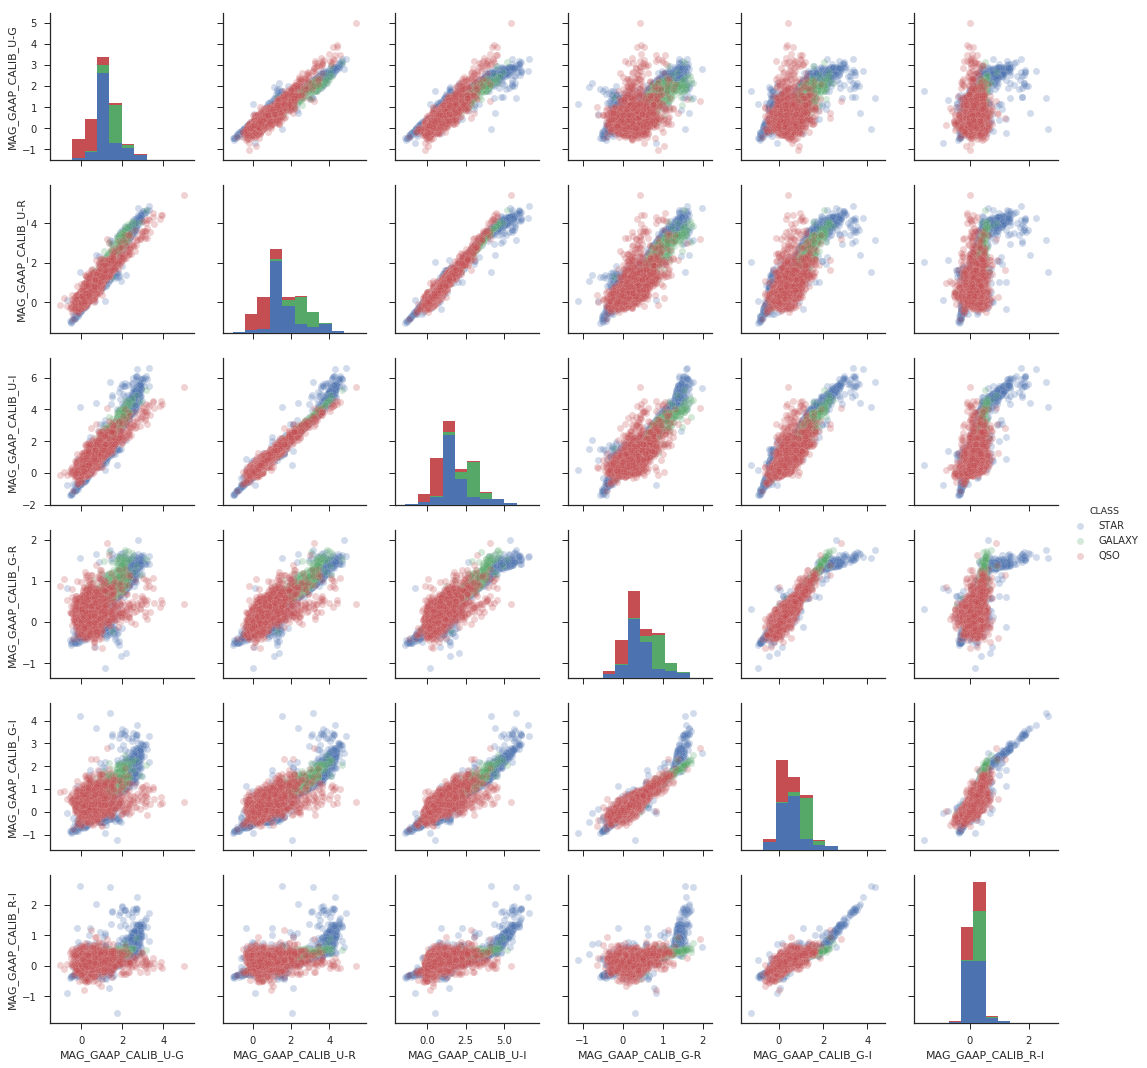

In [101]:
sns.pairplot(kids_x_gaia_clean[np.concatenate([COLOR_COLUMNS, ['CLASS']])], hue='CLASS', plot_kws={'alpha': 0.25})

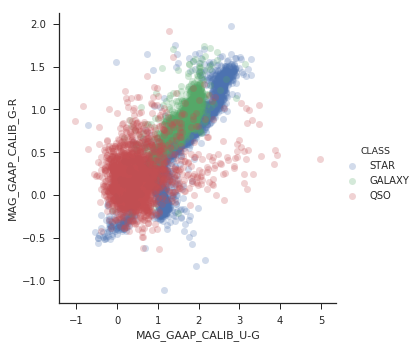

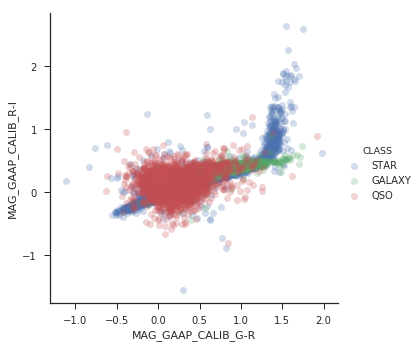

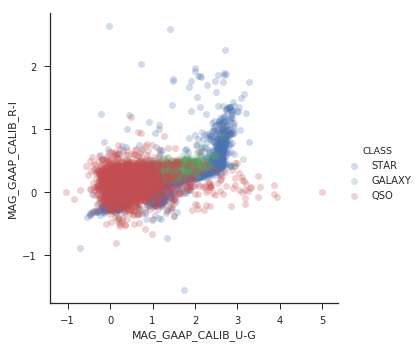

In [100]:
for b_1, b_2 in COLOR_PAIRS:
    sns.set(style='ticks')
    sns.lmplot(x=b_1, y=b_2, hue='CLASS', data=kids_x_gaia_sdss, fit_reg=False, scatter_kws={'alpha': 0.25})

# Bands

## Standalone

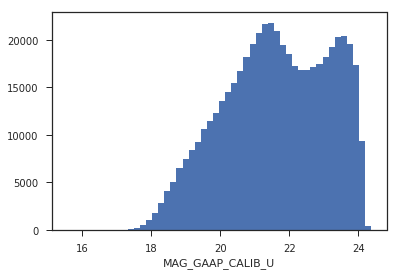

In [14]:
sns.set(style='ticks')
sns.distplot(kids_x_gaia_clean[MAG_GAAP_CALIB_U], kde=False, rug=False, hist_kws={'alpha': 1})

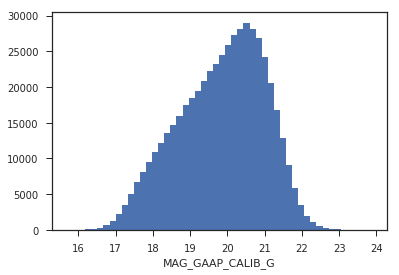

In [15]:
sns.set(style='ticks')
sns.distplot(kids_x_gaia_clean[MAG_GAAP_CALIB_G], kde=False, rug=False, hist_kws={'alpha': 1})

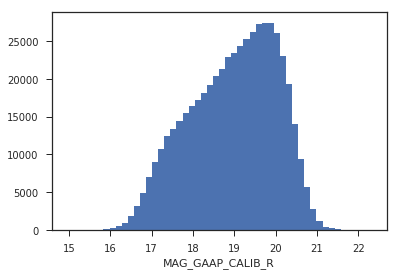

In [16]:
sns.set(style='ticks')
sns.distplot(kids_x_gaia_clean[MAG_GAAP_CALIB_R], kde=False, rug=False, hist_kws={'alpha': 1})

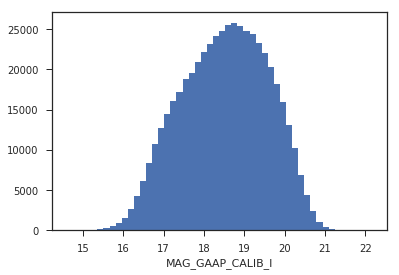

In [17]:
sns.set(style='ticks')
sns.distplot(kids_x_gaia_clean[MAG_GAAP_CALIB_I], kde=False, rug=False, hist_kws={'alpha': 1})

## Paired

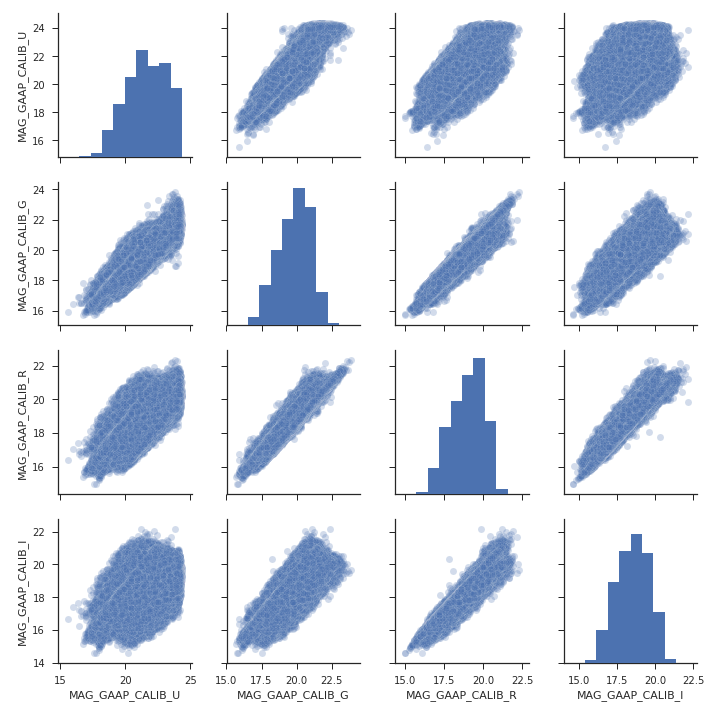

In [18]:
sns.set(style='ticks')
sns.pairplot(X, plot_kws={'alpha': 0.25})

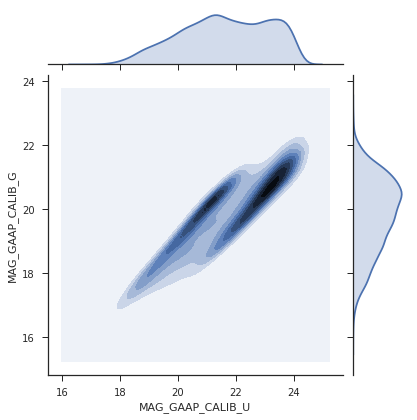

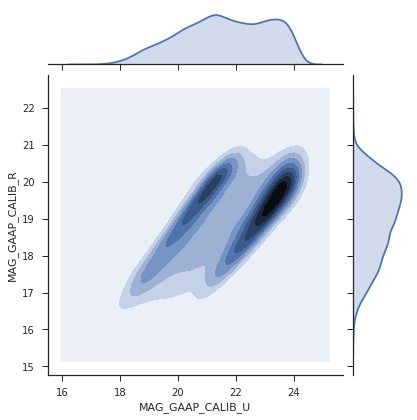

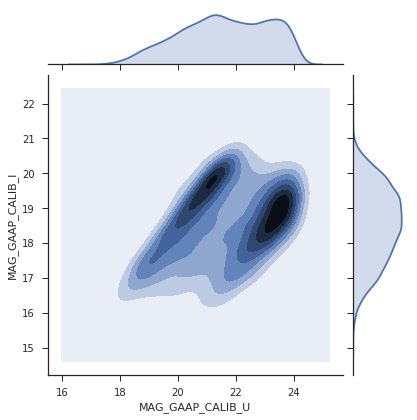

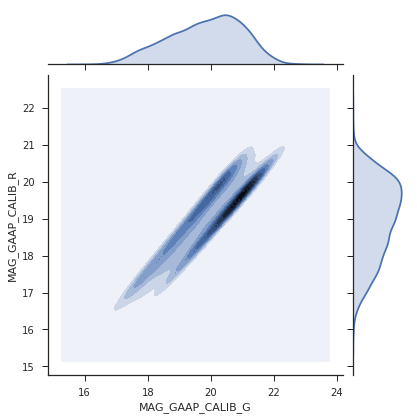

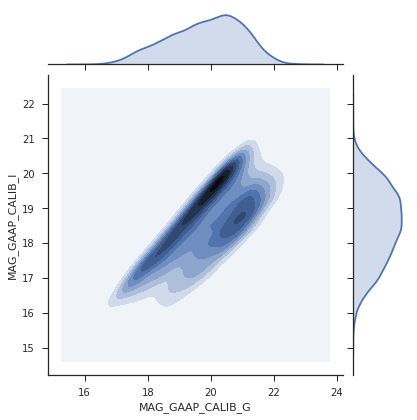

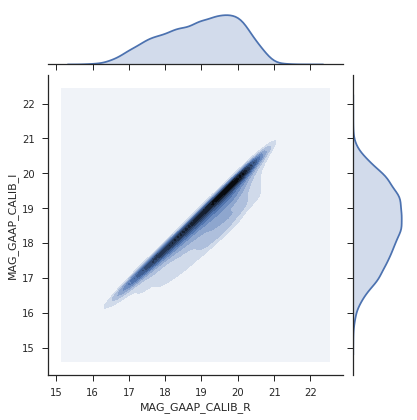

In [19]:
for b_1, b_2 in BAND_PAIRS:
    sns.set(style='ticks')
    sns.jointplot(kids_x_gaia_sampled[b_1], kids_x_gaia_sampled[b_2], kind='kde', stat_func=None)

## Clustered

In [34]:
X_scaled = MinMaxScaler().fit_transform(X_sampled)

In [35]:
X_embedded = TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=1000,
                  n_iter_without_progress=300, min_grad_norm=1e-07, metric='euclidean', init='random', verbose=0,
                  random_state=4680, method='barnes_hut', angle=0.5).fit_transform(X_scaled)

In [36]:
hdb = hdbscan.HDBSCAN(
    min_cluster_size=120, min_samples=1, metric='euclidean', alpha=1.0, p=None, algorithm='best',
    leaf_size=40, approx_min_span_tree=True, gen_min_span_tree=False,
    core_dist_n_jobs=4, cluster_selection_method='eom', allow_single_cluster=False, prediction_data=False,
    match_reference_implementation=False
)

clusterer = hdb.fit(X_scaled)
np.unique(clusterer.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([5664,  171,  147,  305,  305,  217,  192,  163,  197,  137,  370,
         447, 1353,  176,  156]))

In [74]:
report = clustering_report(clusterer.labels_, kids_x_gaia_sampled['CLASS_FILLED'])
display(report)